In [1]:
import numpy as np
import matplotlib.pyplot as plt

def Sigmoid(x):
    return 1/(1+np.exp(-x))

def diffSigmoid(x):
    f = Sigmoid(x)
    return f*(1-f)

def ReLU(x):
    return np.maximum(0.,x)

def diffReLU(x):
    return np.where(x <= 0, 0., 1.)

def Softmax(x):
    return np.exp(x)/sum(np.exp(x))

def diffSoftmax(x):
    return x * (1-x)


In [2]:
def SSE(x,y):
    a = x - y
    return sum(a*a)

def MSE(x,y):
    a = x - y
    return (a*a).mean()

def diffMSE(x,y):
    a = x - y
    return -2*(a)

def ForwardPropagation(weight,bias,input_layer,activation):
    if activation == "Sigmoid" :
        output_layer = Sigmoid(np.dot(weight,input_layer)+bias)
    if activation == "ReLU" :
        output_layer = ReLU(np.dot(weight,input_layer)+bias)
    if activation == "Softmax" :
        output_layer = Softmax(np.dot(weight,input_layer)+bias)    
    return output_layer

def BackPropagation(input_layer,output_layer,activation):
    if activation == "Sigmoid" :
        return np.dot(diffSigmoid(output_layer),input_layer.T) , diffSigmoid(output_layer)
    if activation == "ReLU" :
        return np.dot(diffReLU(output_layer),input_layer.T) , diffReLU(output_layer)
    if activation == "Softmax" :
        return np.dot(diffSoftmax(output_layer),input_layer.T) , diffSoftmax(output_layer)    

def Update(learn_rate,weight,bias,diff_weight,diff_bias):
    return weight-learn_rate*diff_weight , bias-learn_rate*diff_bias
    

In [3]:
import struct

# Read The Mnist dataset 
train_images_idx3_ubyte_file = 'train-images.idx3-ubyte'
train_labels_idx1_ubyte_file = 'train-labels.idx1-ubyte'
test_images_idx3_ubyte_file = 't10k-images.idx3-ubyte'
test_labels_idx1_ubyte_file = 't10k-labels.idx1-ubyte'

def decode_idx3_ubyte(idx3_ubyte_file):
    bin_data = open(idx3_ubyte_file, 'rb').read()
    offset = 0
    fmt_header = '>iiii'
    magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
    image_size = num_rows * num_cols
    offset += struct.calcsize(fmt_header)
    fmt_image = '>' + str(image_size) + 'B'
    images = np.empty((num_images, num_rows, num_cols))

    for i in range(num_images):

        images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))

        offset += struct.calcsize(fmt_image)

    return images

def decode_idx1_ubyte(idx1_ubyte_file):

    bin_data = open(idx1_ubyte_file, 'rb').read()

    offset = 0

    fmt_header = '>ii'

    magic_number, num_images = struct.unpack_from(fmt_header, bin_data, offset)

    offset += struct.calcsize(fmt_header)

    fmt_image = '>B'

    labels = np.empty(num_images)

    for i in range(num_images):

        labels[i] = struct.unpack_from(fmt_image, bin_data, offset)[0]

        offset += struct.calcsize(fmt_image)

    return labels

def load_train_images(idx_ubyte_file=train_images_idx3_ubyte_file):

    return decode_idx3_ubyte(idx_ubyte_file)

def load_train_labels(idx_ubyte_file=train_labels_idx1_ubyte_file):

    return decode_idx1_ubyte(idx_ubyte_file)

def load_test_images(idx_ubyte_file=test_images_idx3_ubyte_file):

    return decode_idx3_ubyte(idx_ubyte_file)

def load_test_labels(idx_ubyte_file=test_labels_idx1_ubyte_file):

    return decode_idx1_ubyte(idx_ubyte_file)

In [4]:
training_images = load_train_images()
training_labels = load_train_labels()
testing_images = load_test_images()
testing_labels = load_test_labels()

In [5]:
print(training_labels.shape)
print(testing_labels.shape)
print(training_images.shape)
print(testing_images.shape)

(60000,)
(10000,)
(60000, 28, 28)
(10000, 28, 28)


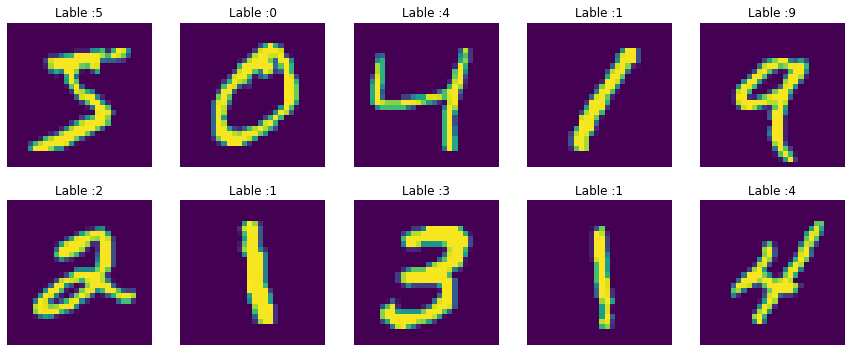

In [6]:
plt.figure(figsize=[15.0,6.0])
length = 5
height = 2
success  = 0
i = 0

for num in range(10):
    label        = int(training_labels[num])
    plt.subplot(height,length,num+1)
    plt.title("Lable :"+str(label),fontsize=12)
    plt.imshow(training_images[num,:,:])
    plt.axis('off')


In [7]:
epochs       = 200
learn_rate   = 0.3
batch_size   = 250

hidden_neural = 300
training_num  = training_images.shape[1] 

training_loss = []
validation_loss = []

# Random initializate the weight and bias value
hidden_layer_weight = np.random.randn(hidden_neural,28*28)
hidden_layer_bias   = np.random.randn(hidden_neural, 1)

output_layer_weight = np.random.randn(10, hidden_neural)
output_layer_bias   = np.random.randn(10, 1)

for epoch in range(epochs):
    loss_ = []
    for num in np.random.randint(1,50000, size=batch_size):
        input_layer  = training_images[num,:,:].reshape(28*28,1)/255.
        label        = np.zeros((10,1))
        label[int(training_labels[num])] = 1.
        
        hidden_layer = ForwardPropagation(hidden_layer_weight,hidden_layer_bias,input_layer,activation="Sigmoid")
        output_layer = ForwardPropagation(output_layer_weight,output_layer_bias,hidden_layer,activation="Softmax")

        loss = MSE(label,output_layer)

        diff_output_layer_loss = diffMSE(label,output_layer)

        ##############################################################################################

        diff_output_layer_weight,diff_output_layer_bias = BackPropagation(hidden_layer,output_layer,activation="Softmax")

        diff_output_layer_weight  *= diff_output_layer_loss
        diff_output_layer_bias    *= diff_output_layer_loss

        ##############################################################################################
        
        diff_hidden_layer_weight,diff_hidden_layer_bias = BackPropagation(input_layer,hidden_layer,activation="Sigmoid")    
        diff_hidden_layer_loss     = np.dot(output_layer_weight.T,diff_output_layer_loss)
    
        diff_hidden_layer_weight  *= diff_hidden_layer_loss
        diff_hidden_layer_bias    *= diff_hidden_layer_loss 

        ##############################################################################################

        hidden_layer_weight,hidden_layer_bias = Update(learn_rate,hidden_layer_weight,hidden_layer_bias,diff_hidden_layer_weight,diff_hidden_layer_bias)
        output_layer_weight,output_layer_bias = Update(learn_rate,output_layer_weight,output_layer_bias,diff_output_layer_weight,diff_output_layer_bias)
        
        loss_.append(loss)
    
    # Training loss    
    training_loss.append(sum(loss_)/training_num) 

    loss_ = []
    
    # Validation
    for num in np.random.randint(50000,60000, size=batch_size):
        input_layer  = training_images[num,:,:].reshape(28*28,1)/255.
        label        = np.zeros((10,1))
        label[int(training_labels[num])] = 1.
        hidden_layer = ForwardPropagation(hidden_layer_weight,hidden_layer_bias,input_layer,activation="Sigmoid")
        output_layer = ForwardPropagation(output_layer_weight,output_layer_bias,hidden_layer,activation="Softmax")
        loss = MSE(label,output_layer)
        loss_.append(loss)    
    
    # Validation loss
    validation_loss.append(sum(loss_)/training_num)    

    if epoch % 10 == 0:
        print("Epoch %d Training loss: %.3f Validation loss: %.3f " % (epoch, training_loss[epoch], validation_loss[epoch]))


Epoch 0 Training loss: 0.980 Validation loss: 0.779 


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Epoch 10 Training loss: 0.344 Validation loss: 0.269 
Epoch 20 Training loss: 0.344 Validation loss: 0.286 
Epoch 30 Training loss: 0.161 Validation loss: 0.236 
Epoch 40 Training loss: 0.285 Validation loss: 0.187 
Epoch 50 Training loss: 0.222 Validation loss: 0.198 
Epoch 60 Training loss: 0.262 Validation loss: 0.196 
Epoch 70 Training loss: 0.205 Validation loss: 0.167 
Epoch 80 Training loss: 0.163 Validation loss: 0.173 
Epoch 90 Training loss: 0.183 Validation loss: 0.197 
Epoch 100 Training loss: 0.186 Validation loss: 0.166 
Epoch 110 Training loss: 0.193 Validation loss: 0.211 
Epoch 120 Training loss: 0.211 Validation loss: 0.150 
Epoch 130 Training loss: 0.178 Validation loss: 0.211 
Epoch 140 Training loss: 0.213 Validation loss: 0.173 
Epoch 150 Training loss: 0.196 Validation loss: 0.166 
Epoch 160 Training loss: 0.189 Validation loss: 0.188 
Epoch 170 Training loss: 0.170 Validation loss: 0.192 
Epoch 180 Training loss: 0.205 Validation loss: 0.179 
Epoch 190 Training 

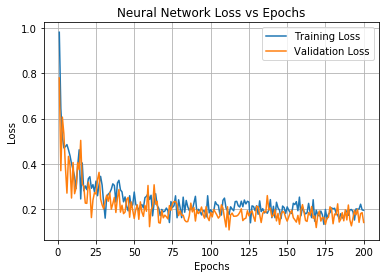

In [8]:
plt.plot(np.arange(1,epochs+1),training_loss, label='Training Loss')
plt.plot(np.arange(1,epochs+1),validation_loss, label='Validation Loss')
plt.title('Neural Network Loss vs Epochs',fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [9]:
test_num = 10000
success  = 0
for num in range(test_num):
    input_layer  = testing_images[num,:,:].reshape(28*28,1)/255.
    hidden_layer = ForwardPropagation(hidden_layer_weight,hidden_layer_bias,input_layer,activation="Sigmoid")
    output_layer = ForwardPropagation(output_layer_weight,output_layer_bias,hidden_layer,activation="Softmax")
    predict      = np.argmax(output_layer)
    label        = int(testing_labels[num])
    if predict==label:
        success += 1

print("Success Rate :",success/test_num)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


Success Rate : 0.8758


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


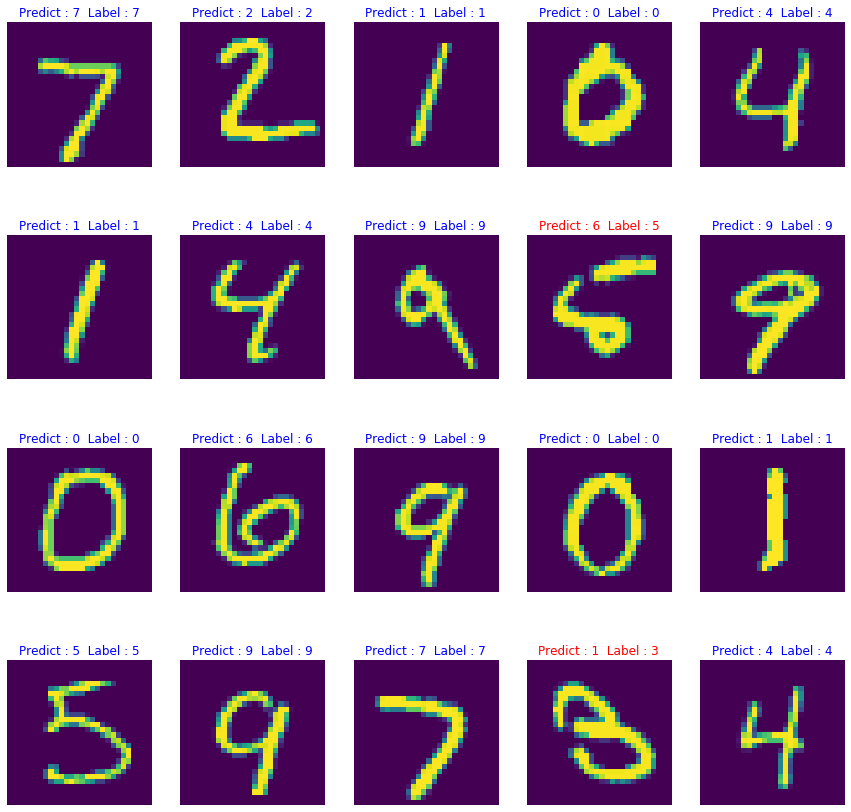

In [10]:
plt.figure(figsize=[15.0,15.0])
length = 5
height = 4
success  = 0
i = 0

for num in range(20):
    input_layer  = testing_images[num,:,:].reshape(28*28,1)/255
    hidden_layer = ForwardPropagation(hidden_layer_weight,hidden_layer_bias,input_layer,activation="Sigmoid")
    output_layer = ForwardPropagation(output_layer_weight,output_layer_bias,hidden_layer,activation="Softmax")
    predict      = np.argmax(output_layer)
    label        = int(testing_labels[num])
    
    i += 1
    plt.subplot(height,length,i)
    if predict==label:
        plt.title("Predict : "+str(predict)+"  Label : "+str(label),fontsize=12,color='blue')
    else:
        plt.title("Predict : "+str(predict)+"  Label : "+str(label),fontsize=12,color='red')
    plt.imshow(testing_images[num,:,:])
    plt.axis('off')
        
